In [4]:
import torch
import torchvision
from matplotlib import pyplot as plt
from torch.nn import Sequential, Flatten, Linear, Module, Conv2d, MaxPool2d, CrossEntropyLoss, Tanh, ReLU, Softmax, \
    BatchNorm2d, Dropout
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Device is set to: {device}")

Device is set to: mps


In [6]:
data = DataLoader(
    datasets.CIFAR10(root="data", train=True, download=True, transform=ToTensor()))
X, _ = next(iter(data))
mean, std = X.mean(), X.std()
del data, X

training_data = datasets.CIFAR10(root="data", train=True, download=True,
                                 transform=Compose([ToTensor(), Normalize(mean, std)]))
test_data = datasets.CIFAR10(root="data", train=False, download=True,
                             transform=Compose([ToTensor(), Normalize(mean, std)]))
print(f'Mean: {mean}, Std: {std}')
print(f'Training data: {len(training_data)}')
print(f'Test data: {len(test_data)}')
print(f'Test data shape: {test_data.data.shape}')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Mean: 0.4056755602359772, Std: 0.20385168492794037
Training data: 50000
Test data: 10000
Test data shape: (10000, 32, 32, 3)


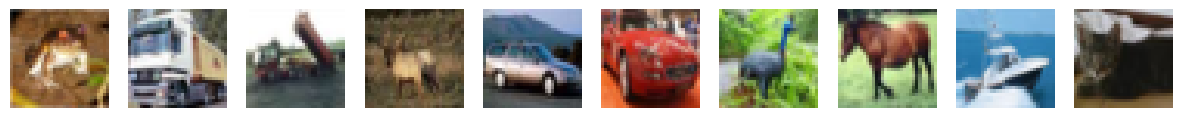

In [7]:
fig, axs = plt.subplots(1, 10, figsize=(15, 15))
for i in range(10):
    # axs[i].set_title(training_data.classes[i] + f': {i}')
    axs[i].imshow(training_data.data[i], cmap='gray')
    axs[i].axis('off')

In [8]:
class EmptyForward(Module):
    @staticmethod
    def forward(x):
        return x


class PrintForward(Module):
    @staticmethod
    def forward(x):
        print(x.shape)
        return x


class CNN(Module):
    def __init__(self, n_channels=3, activation_function=ReLU(), output_activation=Softmax(dim=1),
                 batch_normalization=False, dropout_rate=0):
        super(CNN, self).__init__()
        self.model = Sequential(
            Conv2d(3, 32, 3, 1),  # 32 * 30 * 30
            BatchNorm2d(32) if batch_normalization else EmptyForward(),
            activation_function,
            Conv2d(32, 64, 3, 1),  # 64 * 28 * 28
            BatchNorm2d(64) if batch_normalization else EmptyForward(),
            activation_function,
            MaxPool2d(2, 2),  # 64 * 14 * 14
            Conv2d(64, 128, 3, 1),  # 128 * 12 * 12
            BatchNorm2d(128) if batch_normalization else EmptyForward(),
            activation_function,
            Conv2d(128, 128, 3, 1),  # 128 * 10 * 10
            BatchNorm2d(128) if batch_normalization else EmptyForward(),
            Flatten(),
            Dropout(dropout_rate),
            Linear(128 * 10 * 10, 128),
            BatchNorm2d(64) if batch_normalization else EmptyForward(),
            activation_function,
            Dropout(dropout_rate),
            Linear(128, 64),
            BatchNorm2d(32) if batch_normalization else EmptyForward(),
            activation_function,
            Dropout(dropout_rate),
            Linear(64, 10),
            BatchNorm2d(10) if batch_normalization else EmptyForward(),
            output_activation
        )

    def forward(self, x):
        return self.model(x)

In [9]:
model = CNN()

In [10]:
summary(model, (3, 32, 32))
model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
      EmptyForward-2           [-1, 32, 30, 30]               0
              ReLU-3           [-1, 32, 30, 30]               0
            Conv2d-4           [-1, 64, 28, 28]          18,496
      EmptyForward-5           [-1, 64, 28, 28]               0
              ReLU-6           [-1, 64, 28, 28]               0
         MaxPool2d-7           [-1, 64, 14, 14]               0
            Conv2d-8          [-1, 128, 12, 12]          73,856
      EmptyForward-9          [-1, 128, 12, 12]               0
             ReLU-10          [-1, 128, 12, 12]               0
           Conv2d-11          [-1, 128, 10, 10]         147,584
     EmptyForward-12          [-1, 128, 10, 10]               0
          Flatten-13                [-1, 12800]               0
          Dropout-14                [-1

CNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): EmptyForward()
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): EmptyForward()
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): EmptyForward()
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (11): EmptyForward()
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Dropout(p=0, inplace=False)
    (14): Linear(in_features=12800, out_features=128, bias=True)
    (15): EmptyForward()
    (16): ReLU()
    (17): Dropout(p=0, inplace=False)
    (18): Linear(in_features=128, out_features=64, bias=True)
    (19): EmptyForward()
    (20): ReLU()
    (21): Dropout(p=0, inplace=False)
    (22): Linear(in_features=64, out_features=10, bias=True)
    (23): EmptyForward()
    (24): Softmax(dim=1)
  )
)

In [11]:
def train_plot_model(model):
    n_epochs = 3
    n_batch = 1024
    loss_fn = CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    train_loader = DataLoader(training_data, batch_size=n_batch, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=True)

    train_acc, val_acc = [], []
    train_loss, val_loss = [], []

    for epoch in range(n_epochs):
        local_train_loss, local_train_acc, batch_count = 0, 0, 0
        # enumerate mini batches
        print(f'Epoch: {epoch + 1}')
        for batch_idx, (train_x, train_y) in enumerate(train_loader):
            train_x, train_y = train_x.to(device), train_y.to(device)
            optimizer.zero_grad()
            yhat = model(train_x)
            loss = loss_fn(yhat, train_y)
            loss.backward()
            optimizer.step()

            local_train_loss += loss.item()
            local_train_acc += ((yhat.argmax(1) == train_y).float().mean()).to('cpu')
            batch_count += 1

        with torch.no_grad():
            train_loss.append(local_train_loss / batch_count)
            train_acc.append(local_train_acc / batch_count)
            print(f'Training   -> Loss: {train_loss[-1]:.3f}, Accuracy: {train_acc[-1]:.3f}')
            for test_x, test_y in test_loader:
                test_x, test_y = test_x.to(device), test_y.to(device)
                yhat = model(test_x)
                val_loss.append(loss_fn(yhat, test_y).item())
                val_acc.append(((yhat.argmax(1) == test_y).float().mean()).to('cpu'))
                print(f'Validation -> Loss: {val_loss[-1]:.3f}, Accuracy: {val_acc[-1]:.3f}')
        print('------------------------------------------------')
    plt.figure(1, figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
    return {
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc
    }

In [12]:
result_dict = {}

Regular model
Epoch: 1
Training   -> Loss: 2.360, Accuracy: 0.099
Validation -> Loss: 2.361, Accuracy: 0.100
------------------------------------------------
Epoch: 2
Training   -> Loss: 2.361, Accuracy: 0.100
Validation -> Loss: 2.361, Accuracy: 0.100
------------------------------------------------
Epoch: 3
Training   -> Loss: 2.361, Accuracy: 0.100
Validation -> Loss: 2.361, Accuracy: 0.100
------------------------------------------------


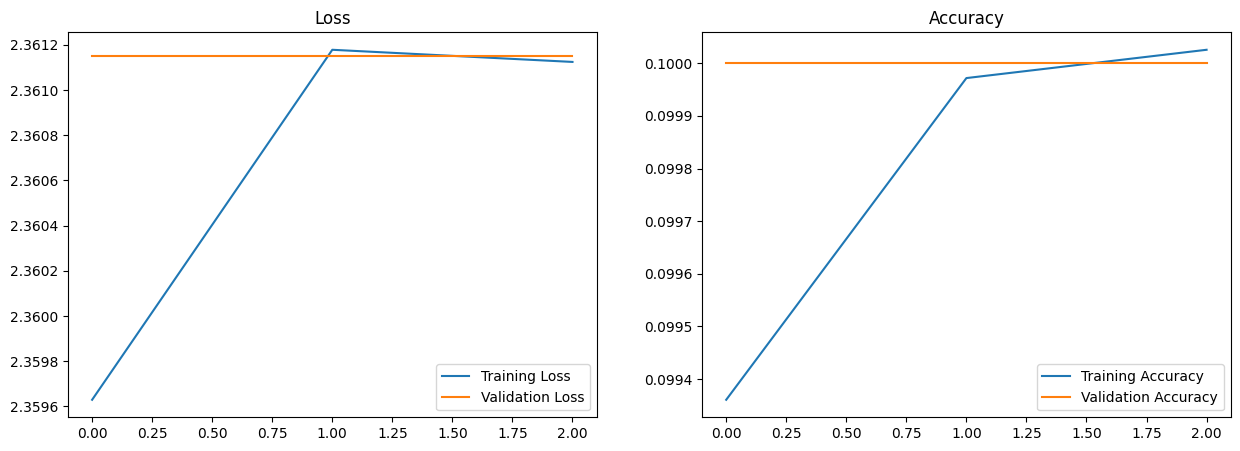

In [13]:
print('Regular model')
result_dict['regular'] = train_plot_model(CNN().to(device))

In [ ]:
print('Tanh model')
result_dict['tanh'] = train_plot_model(CNN(activation_function=Tanh()).to(device))

In [ ]:
print('Batchnorm. ReLU model')
result_dict['batchnorm. ReLU'] = train_plot_model(CNN(batch_normalization=True).to(device))

In [ ]:
print('Batchnorm. Tanh model')
result_dict['batchnorm. Tanh'] = train_plot_model(CNN(activation_function=Tanh(), batch_normalization=True).to(device))

In [ ]:
print('Dropout ReLU model')
result_dict['batchnorm. ReLU'] = train_plot_model(CNN(dropout_rate=0.2).to(device))

In [ ]:
print('Dropout & Batchnorm. ReLU model')
result_dict['batchnorm. ReLU'] = train_plot_model(CNN(dropout_rate=0.2, batch_normalization=True).to(device))

Conclusion

In [ ]:
plt.figure(1, figsize=(15, 5))
plt.subplot(1, 2, 1)
for key, value in result_dict.items():
    plt.plot(value['train_loss'], label=f'{key} Training Loss')
    plt.plot(value['val_loss'], label=f'{key} Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(value['train_acc'], label=f'{key} Training Accuracy')
    plt.plot(value['val_acc'], label=f'{key} Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()